In [1]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
import importlib
if 'AZtutorial' in sys.modules:
    importlib.reload(sys.modules['AZtutorial'])
else:
    import AZtutorial
from AZtutorial import *
from IPython.display import Image


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, PyMol, Crippen, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolTransforms
from tqdm import tqdm
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
import os
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Populating the interactive namespace from numpy and matplotlib


# Step -3. Set up paths for the workflow

In [2]:

# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'


os.environ['GMXLIB'] = "/home/ykhalak/private/gmx_share_top_w_new_vdwradii"

In [3]:
! echo $GMXLIB

/home/ykhalak/private/gmx_share_top_w_new_vdwradii


In [4]:
! which gmx

/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943/bin/gmx


# Step -2. Select ligands

In [5]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        print(i)
        reference_lig_id=i
        
reference_lig=training_ligs[reference_lig_id]

del training_ligand_databse_fn,training_ligs
import gc
gc.collect()

54


0

In [6]:
folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09_filtered_subset/"

with open(pocket_fit_folder+"/worst_unmeasured_ligs_according_to_predictions_of_step_5.pickle", 'rb') as f:
    test_ligs = pickle.load(f)

In [ ]:
Draw.MolsToGridImage(test_ligs+[reference_lig],
                     legends=[l.GetProp("ID") for l in test_ligs+[reference_lig]],
                     subImgSize = (400,400), molsPerRow=5, maxMols=101)

# Step -1. Properly parametrize ligands

In [8]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
    mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
    mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
    
    mol_pdb=f"{mol_folder}/mol_gmx.pdb"
    if(not os.path.exists(mol_pdb)):
        with open(mol_pdb,"w") as f:
            f.write(rdmolfiles.MolToPDBBlock(mol))
            
    mol_itp=mol_folder+"/MOL.acpype/MOL_GMX.itp"
    if(not os.path.exists(mol_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        mol_file = "MOL.mol"
        process = subprocess.Popen(['acpype', '-i', mol_file, '-a', 'gaff', '-c', 'bcc', '-b', "MOL", '-n', repr(totQ)],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
        process.wait()
#         out=process.stdout.read().decode("utf-8")
#         err=process.stderr.read().decode("utf-8")
#         print(out)
#         print(err)

        os.system("sed '/\\[ moleculetype \\]/Q' MOL.acpype/MOL_GMX.itp > ffMOL.itp 2>&1")
        os.system("sed -n '/\\[ moleculetype \\]/,$p' MOL.acpype/MOL_GMX.itp > MOL.itp  2>&1")

#         #make sigmahole versions
#         os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
#                   " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
#                   " -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
        mp_lock.acquire()
        if(not os.path.exists(mol_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
        mp_lock.release()
#         break;
    else:
        mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
        mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])

print("Now the pool is closed and no longer available")

set4_138367 	 starting in process 2869
set4_245792 	 starting in process 2870
set4_139766 	 starting in process 2871
set4_250715 	 starting in process 2872
set4_250715 	 done parametrizing
set4_246640 	 starting in process 2872
set4_245792 	 done parametrizing
set4_143404 	 starting in process 2870
set4_143404 	 done parametrizing
set4_246709 	 starting in process 2870
set4_138367 	 done parametrizing
set4_246220 	 starting in process 2869
set4_246709 	 done parametrizing
set4_139401 	 starting in process 2870
set4_246220 	 done parametrizing
set4_36 	 starting in process 2869
set4_139766 	 done parametrizing
set4_247744 	 starting in process 2871
set4_36 	 done parametrizing
set4_374509 	 starting in process 2869
set4_374509 	 done parametrizing
set4_139380 	 starting in process 2869
set4_246640 	 done parametrizing
set4_140131 	 starting in process 2872
set4_139401 	 done parametrizing
set4_374498 	 starting in process 2870
set4_247744 	 done parametrizing
set4_246706 	 starting in p

In [9]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
#     mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
#     mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
            
    mol_sigmahole_itp=mol_folder+"/MOL_sigmahole.itp"
    if(not os.path.exists(mol_sigmahole_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        
        #make sigmahole versions
        os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
                  " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
                  f" -q {totQ} -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
#         mp_lock.acquire()
        if(not os.path.exists(mol_sigmahole_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
#         mp_lock.release()
#         break;
    else:
#         mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
#         mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])



set4_138367 	 starting in process 13238set4_245792
 	 starting in process 13239
set4_250715set4_139766  	 starting in process	 starting in process  1324013241

set4_245792set4_250715  	 done parametrizing
set4_246640 	 starting in process 13241
	 done parametrizing
set4_143404 	 starting in process 13239
set4_138367 	 done parametrizing
set4_246220 	 starting in process 13238
set4_139766 	 done parametrizing
set4_247744 	 starting in process 13240
set4_143404 	 done parametrizing
set4_246709 	 starting in process 13239
set4_246220 	 done parametrizing
set4_36 	 starting in process 13238
set4_247744 	 done parametrizing
set4_246706 	 starting in process 13240
set4_246640 	 done parametrizing
set4_140131 	 starting in process 13241
set4_246709 	 done parametrizing
set4_139401 	 starting in process 13239
set4_246706 	 done parametrizing
set4_246699 	 starting in process 13240
set4_36 	 done parametrizing
set4_374509 	 starting in process 13238
set4_140131 	 done parametrizing
set4_246682 

# Step 0. Initialize working environment

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [8]:
# provide edges
fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe.simTypes = ['em','eq_posre','eq','transitions']
#fe.simTypes = ['em','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )


edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_140131
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_5673
edge_JAN_PDE2_1345_set

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [11]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False, n_processes=8)
#fe.atom_mapping(bVerbose=True)

-----------------------
Performing atom mapping
-----------------------
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_246681
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_246707
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_247744
edge_JAN_P

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [ ]:
# import importlib
# if 'AZtutorial' in sys.modules:
#     importlib.reload(sys.modules['AZtutorial'])
# else:
#     import AZtutorial
# from AZtutorial import *

# # initialize the free energy environment object: it will store the main parameters for the calculations
# fe = AZtutorial( )

# # set the workpath
# fe.workPath = 'workpath'
# # set the path to the molecular dynamics parameter files
# fe.mdpPath = 'input/mdppath'
# # set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
# fe.replicas = 3
# # provide the path to the protein structure and topology
# fe.proteinPath = 'input/protein_amber'
# # provide the path to the folder with ligand structures and topologies
# fe.ligandPath = 'input/ligands'

# # provide edges
# fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
# fe.simTypes = ['em','eq_posre','eq','transitions']
# #fe.simTypes = ['em','eq','transitions']

# # finally, let's prepare the overall free energy calculation directory structure
# fe.prepareFreeEnergyDir( )

In [12]:
fe.hybrid_structure_topology(bVerbose=False, n_processes=1, DummyMassScale=0.001)

----------------------------------
Creating hybrid structure/topology
----------------------------------
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_140131
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_246696
edge

`1c. Generate position restraints for the ligands`

In [13]:
fe.hybrid_structure_restraints(bVerbose=False, n_processes=8)

-----------------------------------------------
Creating position restraints for hybrid ligands
-----------------------------------------------
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_5673
ed

`1d. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [17]:
prot_extra_mols={}
prot_extra_mols["MG"]=1
prot_extra_mols["ZN"]=1
prot_extra_mols["SOL"]=88

fe.assemble_systems( filter_prot_water=True, prot_extra_mols=prot_extra_mols)

----------------------
Assembling the systems
----------------------
edge_JAN_PDE2_1345_set4_138367


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "


edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_374509
changing number of waters to 

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


87
edge_JAN_PDE2_1345_set4_139380
changing number of waters to 87
edge_JAN_PDE2_1345_set4_5661
changing number of waters to 87
edge_JAN_PDE2_1345_set4_143343
changing number of waters to 87
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_143404
changing number of waters to 87
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_139401
changing number of waters to 87
edge_JAN_PDE2_1345_set4_374498
changing number of waters to 87
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_139766
changing number of waters to 87
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_139379
changing number of waters to 87
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246640
changing number of waters to 87
edge_JAN_PDE2_1345_set4_140131
changing number of waters to 87
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_138508

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [18]:
fe.boxWaterIons(    bBoxLig=True, bBoxProt=True, 
                    bWatLig=True, bWatProt=True,
                    bIonLig=True, bIonProt=True, n_processes=4 )

----------------
Box, water, ions
----------------
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_250715


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_246640


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! IndexFile has group MG !! 

Group MG will be replaced !!
IndexFile has group ZN !! Group ZN will be replaced !!

IndexFile has group UNL !! 
Group UNL will be replaced !!Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!

IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_140131
edge_JAN_PDE2_1345_set4_36


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! IndexFile has group MG !! 

Group UNL will be replaced !!Group MG will be replaced !!

IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139401


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246641


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139380


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_138508


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246672


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_5661


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_143343


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_245644
edge_JAN_PDE2_1345_set4_3288
edge_JAN_PDE2_1345_set4_246700


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246707
edge_JAN_PDE2_1345_set4_139381
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_1085


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
IndexFile has group MG !! Group MG will be replaced !!

Group MG will be replaced !!
IndexFile has group ZN !! 
IndexFile has group ZN !! Group ZN will be replaced !!

Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_142832
edge_JAN_PDE2_1345_set4_139550
edge_JAN_PDE2_1345_set4_581
edge_JAN_PDE2_1345_set4_10


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! IndexFile has group MG !! 
Group MG will be replaced !!

Group ZN will be replaced !!
IndexFile has group UNL !! IndexFile has group ZN !! 
Group UNL will be replaced !!
Group ZN will be replaced !!

IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_5673
edge_JAN_PDE2_1345_set4_246680


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246644


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_138455


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246681
edge_JAN_PDE2_1345_set4_29


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_3218


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246687


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_6254
edge_JAN_PDE2_1345_set4_138445


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_1082


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246663
edge_JAN_PDE2_1345_set4_139384
edge_JAN_PDE2_1345_set4_139314
edge_JAN_PDE2_1345_set4_2354


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246651
edge_JAN_PDE2_1345_set4_139353
edge_JAN_PDE2_1345_set4_138457
edge_JAN_PDE2_1345_set4_139333


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_5598
edge_JAN_PDE2_1345_set4_591
edge_JAN_PDE2_1345_set4_139535
edge_JAN_PDE2_1345_set4_141591


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139359
edge_JAN_PDE2_1345_set4_246638
edge_JAN_PDE2_1345_set4_246695
edge_JAN_PDE2_1345_set4_246658


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246685
edge_JAN_PDE2_1345_set4_246702
edge_JAN_PDE2_1345_set4_143416
edge_JAN_PDE2_1345_set4_246683


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139681
edge_JAN_PDE2_1345_set4_138503
edge_JAN_PDE2_1345_set4_247454
edge_JAN_PDE2_1345_set4_246653


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_374506
edge_JAN_PDE2_1345_set4_138805


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246704
edge_JAN_PDE2_1345_set4_139331
edge_JAN_PDE2_1345_set4_139335
edge_JAN_PDE2_1345_set4_138817


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_143489
edge_JAN_PDE2_1345_set4_3203
edge_JAN_PDE2_1345_set4_139330
edge_JAN_PDE2_1345_set4_139321


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
IndexFile has group MG !! Group MG will be replaced !!
Group MG will be replaced !!

IndexFile has group ZN !! 
Group ZN will be replaced !!IndexFile has group ZN !! 

Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246662
edge_JAN_PDE2_1345_set4_246643
edge_JAN_PDE2_1345_set4_246688
edge_JAN_PDE2_1345_set4_246637


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_138452
edge_JAN_PDE2_1345_set4_374966
edge_JAN_PDE2_1345_set4_139328


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! IndexFile has group ZN !! 
Group ZN will be replaced !!

IndexFile has group UNL !! Group ZN will be replaced !!

Group UNL will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_143197
edge_JAN_PDE2_1345_set4_138440


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139547
edge_JAN_PDE2_1345_set4_246666


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_246645
edge_JAN_PDE2_1345_set4_139693


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_139316
edge_JAN_PDE2_1345_set4_246654


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


DONE


`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [17]:
fe.prepare_simulation( simType='em', bLig=True, bProt=True, n_processes=8  )

-----------------------------------------
Preparing simulation: em
-----------------------------------------
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_5673
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_374498
edge_J

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
#fe.run_simulation_locally( simType='em', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads_d"])

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [ ]:
# set several parameters
#fe.JOBqueue = 'SGE'
#fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
#fe.JOBpartition = 'p20'

fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

In [18]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


# Check what stages are finished

In [21]:
print("protein:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                


# simType='eq_posre'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")
                
# simType='eq'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")

protein:
	 em


In [20]:
print("water:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
# simType='eq'
# print("\t", simType)
# for edge in fe.edges:
#     for state in fe.states:
#         for r in range(1,fe.replicas+1):
#             simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
#             if(not os.path.exists(f"{simpath}/confout.gro")):
#                 print(f"Not finished: {edge} {state} {r}")

water:
	 em


# Posre only for Prot

`prepare and run NVT with simulated annealing to get the temp up smoothly`

In [22]:
fe.prepare_simulation( simType='eq_posre', bProt=True, bLig=False, n_processes=8)

-----------------------------------------
Preparing simulation: eq_posre
-----------------------------------------
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_13937

In [ ]:
#fe.run_simulation_locally( simType='eq_posre', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

In [ ]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
fe.JOBpartition = 'p20'
#fe.JOBpartition = 'p20,p16,p10,p08'

fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

In [23]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
#fe.JOBsimcpu = 10
fe.JOBsimcpu = 4
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


### Check eq_posre completition

In [12]:
simType='eq_posre'
for
edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

Not finished: edge_JAN_PDE2_1345_set4_138455 stateB 2


In [ ]:
# # TI xvgs are incomplete and NPT took a long time
# unstable_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
# ]

# stable_edges={e:fe.edges[e] for e in fe.edges if e not in unstable_edges_names}

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [24]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=stable_edges)
# fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_245792
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_246681
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_6254
edge_J

In [ ]:
#fe.run_simulation_locally( simType='eq', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [34]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 23 # hours
#fe.JOBpartition = 'p20'
fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


In [32]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 23 # hours

#fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_138508
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_246641
edge_JAN_PDE2_1345_set4_246672
edge_JAN_PDE2_1345_set4_143343
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_246640
edge_JAN_PDE2_1345_set4_10
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_139379
edge_JAN_PDE2_1345_set4_139552
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_247744
edge

# exclude slow running edges (NPT not done yet)

In [35]:
# find slow-running edges
slow_edges_names=[]

simType='eq'
print("\t", simType)
print("\t\t protein")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
print("\t\t water")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
#make sure they are unique
slow_edges_names=list(set(slow_edges_names))

	 eq
		 protein
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 3
Not finished: edge_JAN_PDE2_1345_set4_139550 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_139550 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_139550 stateB 3
Not finished: edge_JAN_PDE2_1345_set4_138455 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_138455 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_138455 stateB 3
Not finished: edge_JAN_PDE2_1345_set4_139535 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_139535 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_139535 stateB 3
Not finished: edge_JAN_PDE2_1345_set4_139331 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_139331 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_139547 stateB 2
		 water
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_139552 stateB 3
Not

In [ ]:
# slow_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596"
# ]

In [36]:
normal_edges={e:fe.edges[e] for e in fe.edges if e not in slow_edges_names}
slow_edges={e:fe.edges[e] for e in fe.edges if e in slow_edges_names}
print(slow_edges)

{'edge_JAN_PDE2_1345_set4_139552': ['JAN_PDE2_1345', 'set4_139552'], 'edge_JAN_PDE2_1345_set4_139550': ['JAN_PDE2_1345', 'set4_139550'], 'edge_JAN_PDE2_1345_set4_138455': ['JAN_PDE2_1345', 'set4_138455'], 'edge_JAN_PDE2_1345_set4_139535': ['JAN_PDE2_1345', 'set4_139535'], 'edge_JAN_PDE2_1345_set4_139331': ['JAN_PDE2_1345', 'set4_139331'], 'edge_JAN_PDE2_1345_set4_139547': ['JAN_PDE2_1345', 'set4_139547']}


# Run TI on the edges that finished eq
no unstable opnes this time

In [37]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 12 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=normal_edges )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=slow_edges, job_folder_suffix="_from_slow_NPT" )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# Check structure of unstable lig

In [ ]:
unstable_ligs=[]
unstable_lignames=[]
for i,l in enumerate(test_ligs):
    if("edge_JAN_PDE2_1345_"+l.GetProp("ID") in unstable_edges_names):
        unstable_ligs.append(l)
        unstable_lignames.append(l.GetProp("ID"))

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(lig))for lig in unstable_ligs], legends=unstable_lignames,
                     subImgSize = (200,200), molsPerRow=2, maxMols=10)

# Analysis

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [ ]:
# # TI xvgs are incomplete and NPT took a long time
# not_finsished_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596",
# #     "edge_JAN_PDE2_1345_set4_42807",
# #     "edge_JAN_PDE2_1345_set4_375984"
# ]

# finished_edges={e:fe.edges[e] for e in fe.edges if e not in not_finsished_edges_names}

In [59]:
# build a list of finished edges

finished_edges_names=[]

for edge in tqdm(fe.edges):
    fin=[False]*fe.replicas
    for r in range(1,fe.replicas+1):
        # ligand
        wp = 'water'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_w = glob.glob('{0}/*xvg'.format(stateApath))
        gB_w = glob.glob('{0}/*xvg'.format(stateBpath))

        # protein
        wp = 'protein'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_p = glob.glob('{0}/*xvg'.format(stateApath))
        gB_p = glob.glob('{0}/*xvg'.format(stateBpath))

        if(len(gA_w)>=80 and len(gB_w)>=80 and len(gA_p)>=80 and len(gB_p)>=80):
            fin[r-1]=True
    if(all(fin)):
        finished_edges_names.append(edge)

finished_edges={e:fe.edges[e] for e in finished_edges_names}
# print(finished_edges)
print(len(finished_edges))

100%|██████████| 100/100 [00:10<00:00,  9.31it/s]

94


In [60]:
#fe.run_analysis( bVerbose=True)

# excluded=["edge_JAN_PDE2_1345_JAN_PDE2_994"] # we don't have water for this one yet
# ana_edges={x: fe.edges[x] for x in fe.edges if x not in excluded}
# fe.run_analysis(edges=ana_edges, bLig=False, bProt=True, bVerbose=False)

# fe.run_analysis( bLig=False, bProt=True, bVerbose=False)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False, only_check_completition=True)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False,
#                  n_processes=min(8, len(finished_edges)),
#                  edges=finished_edges )
fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8)

----------------
Running analysis
----------------
edge_JAN_PDE2_1345_set4_139380
edge_JAN_PDE2_1345_set4_138367
edge_JAN_PDE2_1345_set4_246706
edge_JAN_PDE2_1345_set4_246682
edge_JAN_PDE2_1345_set4_3220
edge_JAN_PDE2_1345_set4_143404
edge_JAN_PDE2_1345_set4_139385
edge_JAN_PDE2_1345_set4_246696
edge_JAN_PDE2_1345_set4_246699
edge_JAN_PDE2_1345_set4_5661
edge_JAN_PDE2_1345_set4_250715
edge_JAN_PDE2_1345_set4_246220
edge_JAN_PDE2_1345_set4_246676
edge_JAN_PDE2_1345_set4_246701
edge_JAN_PDE2_1345_set4_246709
edge_JAN_PDE2_1345_set4_36
edge_JAN_PDE2_1345_set4_139766
edge_JAN_PDE2_1345_set4_374509
edge_JAN_PDE2_1345_set4_139401
edge_JAN_PDE2_1345_set4_246681
edge_JAN_PDE2_1345_set4_247744
edge_JAN_PDE2_1345_set4_374498
edge_JAN_PDE2_1345_set4_6254
edge_JAN_PDE2_1345_set4_246707
edge_JAN_PDE2_1345_set4_1082
edge_JAN_PDE2_1345_set4_2354
edge_JAN_PDE2_1345_set4_139314
edge_JAN_PDE2_1345_set4_139550
edge_JAN_PDE2_1345_set4_245644
edge_JAN_PDE2_1345_set4_3288
edge_JAN_PDE2_1345_set4_142832
edge

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [61]:
fe.replicas = 3
fe.analysis_summary( edges=finished_edges )
# fe.analysis_summary()

In [62]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_JAN_PDE2_1345_set4_138367_water_1,-369.950000,1.050000,0.630000,80.0,80.0
edge_JAN_PDE2_1345_set4_138367_protein_1,-376.810000,1.740000,0.950000,80.0,80.0
edge_JAN_PDE2_1345_set4_138367_water_2,-364.640000,1.850000,1.440000,80.0,80.0
edge_JAN_PDE2_1345_set4_138367_protein_2,-366.920000,3.390000,2.240000,80.0,80.0
edge_JAN_PDE2_1345_set4_138367_water_3,-368.690000,0.730000,0.740000,80.0,80.0
...,...,...,...,...,...
edge_JAN_PDE2_1345_set4_246653_protein,-403.816667,4.524519,1.408591,NaN,NaN
edge_JAN_PDE2_1345_set4_139330_water,127.326667,0.999270,0.985867,NaN,NaN
edge_JAN_PDE2_1345_set4_139330_protein,129.863333,3.711021,1.819090,NaN,NaN
edge_JAN_PDE2_1345_set4_246662_water,-237.330000,0.673443,0.730739,NaN,NaN


In [63]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsAll)

                                                 val  err_analyt  err_boot  \
edge_JAN_PDE2_1345_set4_138367_water_1   -369.950000    1.050000  0.630000   
edge_JAN_PDE2_1345_set4_138367_protein_1 -376.810000    1.740000  0.950000   
edge_JAN_PDE2_1345_set4_138367_water_2   -364.640000    1.850000  1.440000   
edge_JAN_PDE2_1345_set4_138367_protein_2 -366.920000    3.390000  2.240000   
edge_JAN_PDE2_1345_set4_138367_water_3   -368.690000    0.730000  0.740000   
edge_JAN_PDE2_1345_set4_138367_protein_3 -364.080000    1.950000  0.550000   
edge_JAN_PDE2_1345_set4_246220_water_1   -551.050000    0.990000  1.120000   
edge_JAN_PDE2_1345_set4_246220_protein_1 -547.350000    1.320000  1.530000   
edge_JAN_PDE2_1345_set4_246220_water_2   -550.000000    1.290000  1.260000   
edge_JAN_PDE2_1345_set4_246220_protein_2 -554.330000    4.930000  0.970000   
edge_JAN_PDE2_1345_set4_246220_water_3   -550.230000    0.930000  1.210000   
edge_JAN_PDE2_1345_set4_246220_protein_3 -551.780000    1.910000

In [64]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsSummary)

                                      val  err_analyt  err_boot
edge_JAN_PDE2_1345_set4_138367  -1.510000    3.748830  3.528778
edge_JAN_PDE2_1345_set4_246220  -0.726667    2.551542  1.965287
edge_JAN_PDE2_1345_set4_36       5.690000    1.824485  1.698599
edge_JAN_PDE2_1345_set4_374509   5.243333    3.110103  3.188262
edge_JAN_PDE2_1345_set4_139380  -0.646667    6.107892  3.436261
edge_JAN_PDE2_1345_set4_143343  -3.653333    5.559496  3.493959
edge_JAN_PDE2_1345_set4_245792  -3.776667   17.052605  4.483700
edge_JAN_PDE2_1345_set4_143404   5.153333    4.639418  4.328630
edge_JAN_PDE2_1345_set4_246709  -7.653333    2.906746  2.879139
edge_JAN_PDE2_1345_set4_139401   9.953333   73.874956  3.201667
edge_JAN_PDE2_1345_set4_374498   2.653333    3.425239  2.070348
edge_JAN_PDE2_1345_set4_3220     3.950000    2.494143  2.458331
edge_JAN_PDE2_1345_set4_246701  -0.803333    2.838748  2.392059
edge_JAN_PDE2_1345_set4_139766  -0.156667    4.463893  4.447199
edge_JAN_PDE2_1345_set4_247744   5.47666

In [65]:
def grid_mols_with_annotation(mols, labels, sub_img_size=(250,250), mols_per_row=10, title="", annotation_size=22, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, maxMols=len(mols), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size[0]/2, sub_img_size[1]+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size[0], text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size[0]/2, text_pos[1] + sub_img_size[1])

    ax.imshow(img, origin="upper")

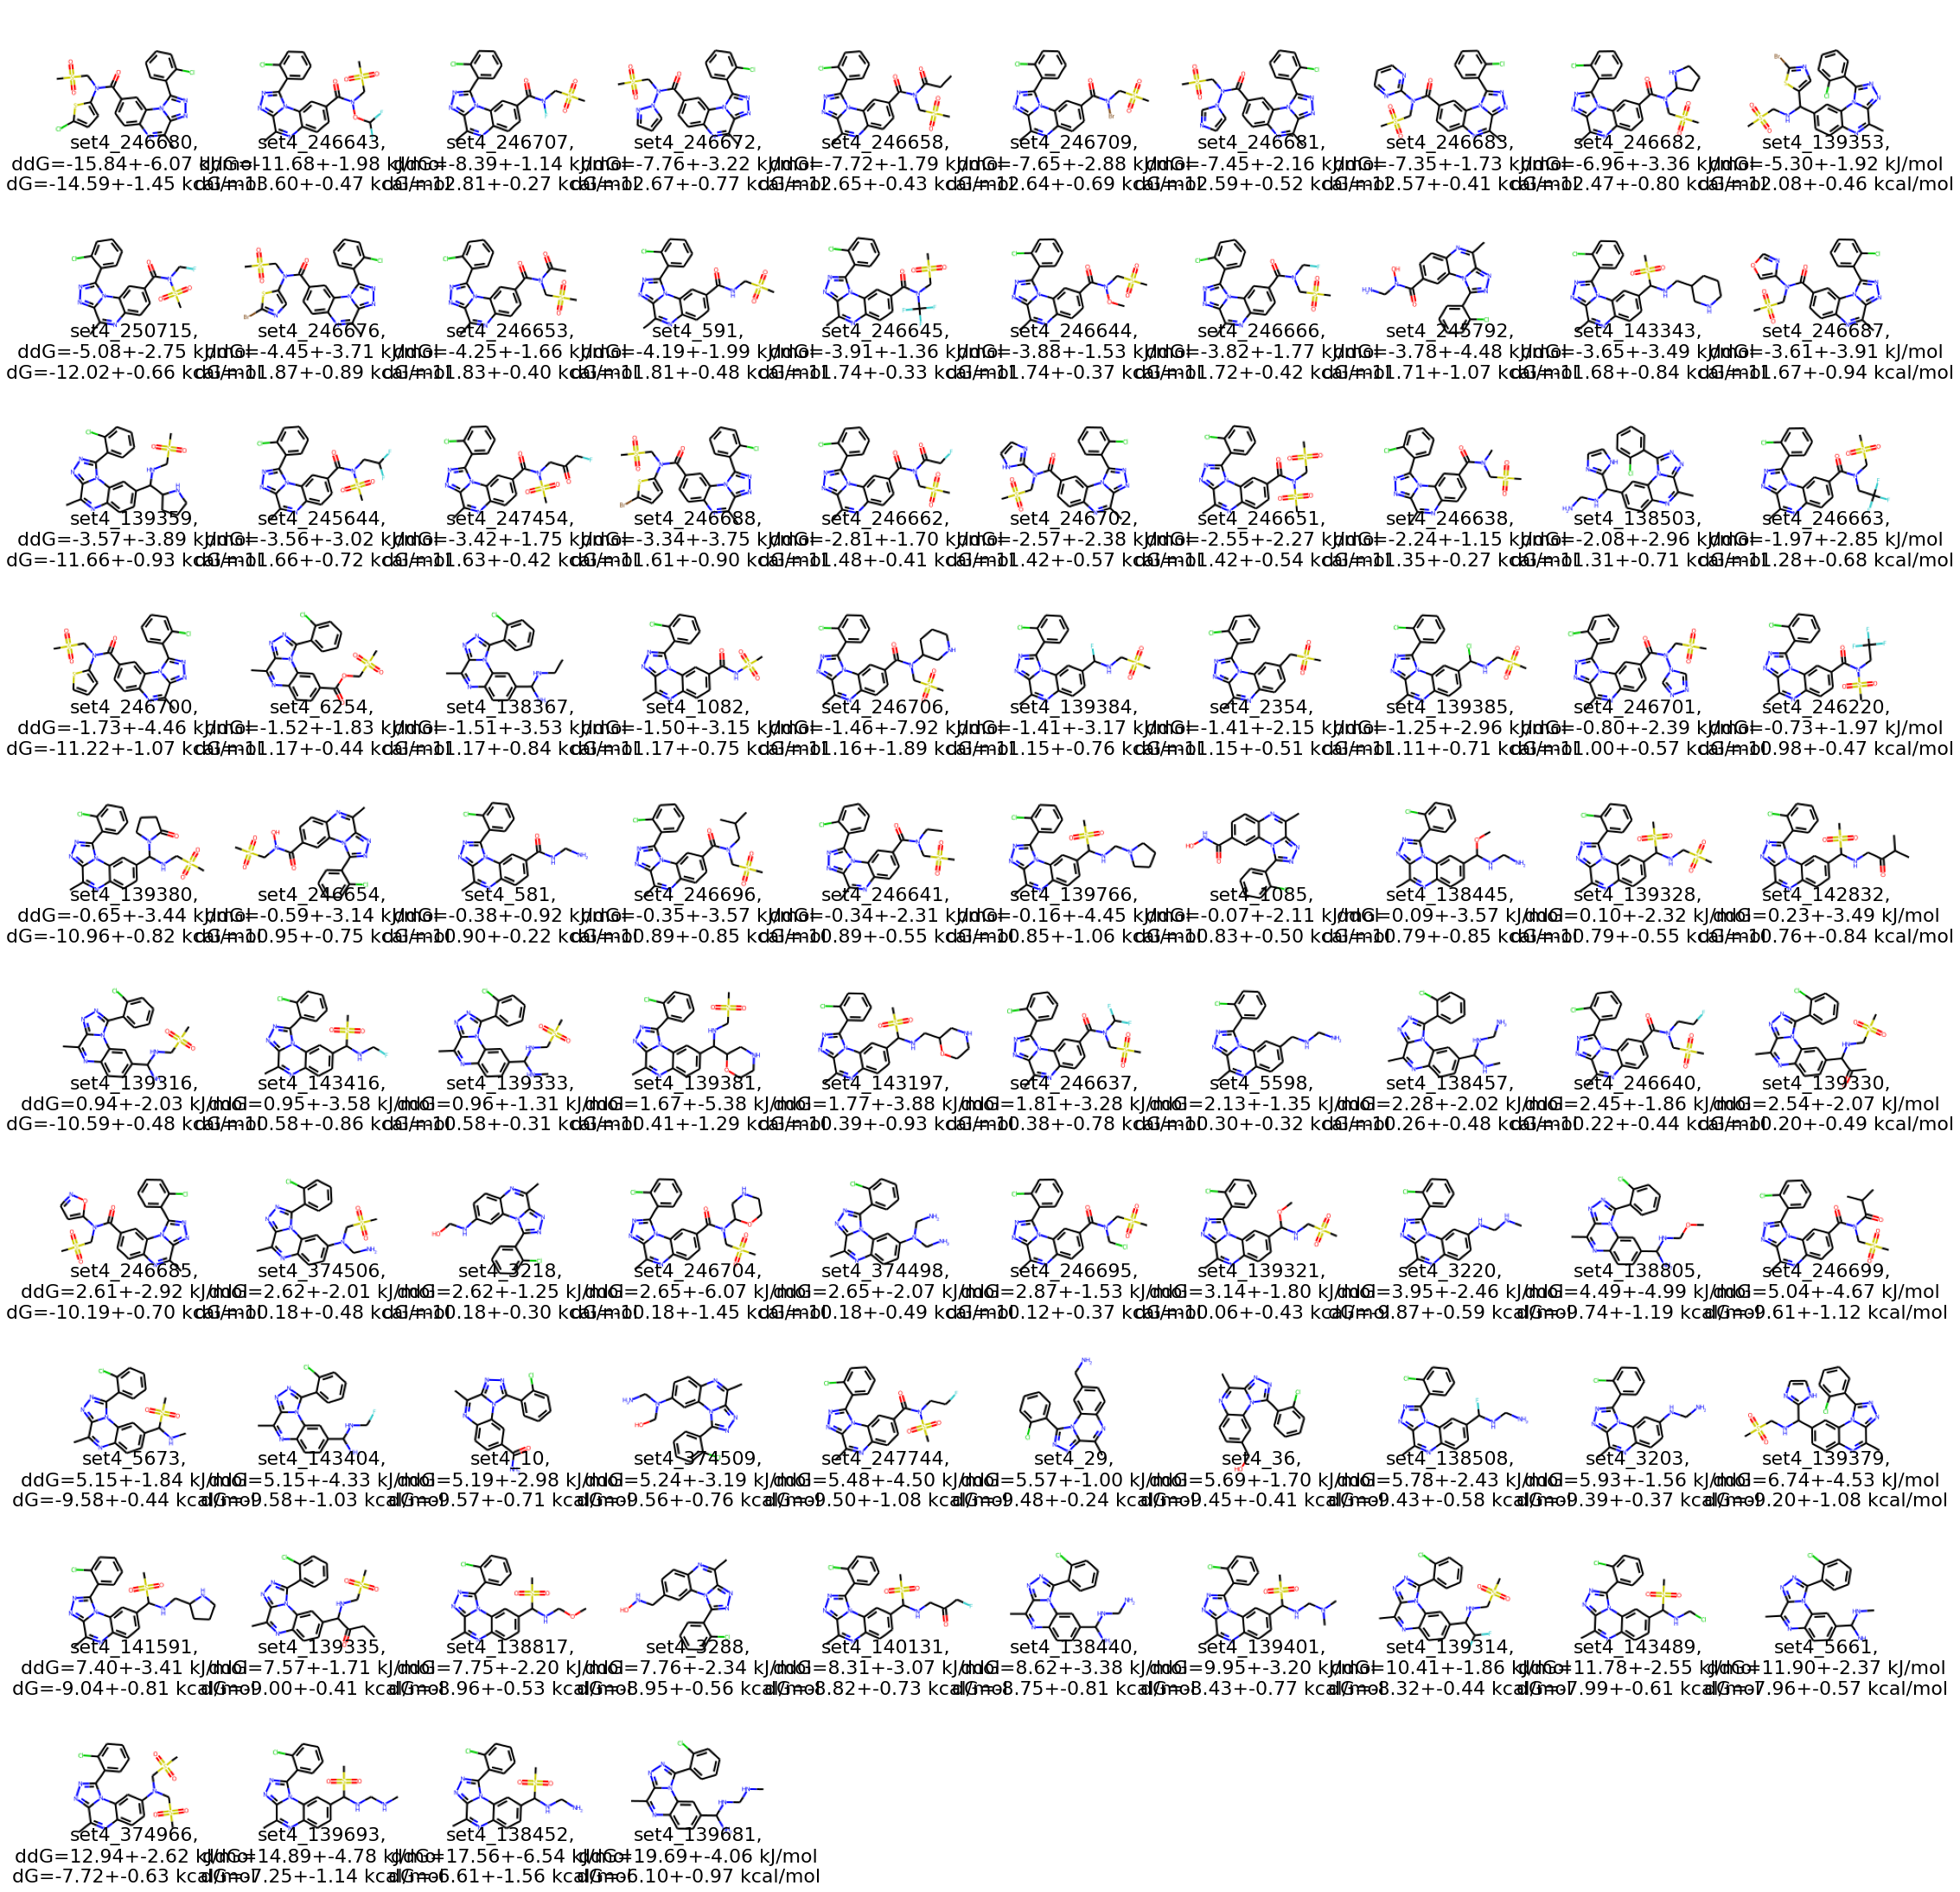

In [66]:
cutoff_ddg=-16

cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

tight_binders=[]
legends=[]
tight_dGs=[]
for i,l in enumerate(test_ligs):
    edge=f"edge_JAN_PDE2_1345_{l.GetProp('ID')}"
    if(edge in finished_edges):
        val=fe.resultsSummary.at[edge,'val']
        uncert=fe.resultsSummary.at[edge,'err_boot']
#         if(val<cutoff_ddg):
        tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(l)))
        legends.append(f"{l.GetProp('ID')},\nddG={val:.2f}+-{uncert:.2f} kJ/mol\ndG={fe.resultsSummary.loc[edge,'val']/cal2J + red_dG: .2f}+-{uncert/cal2J:.2f} kcal/mol")
        tight_dGs.append(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG)
order=np.argsort(tight_dGs)
            
# Draw.MolsToGridImage([tight_binders[i] for i in order],
#                      legends=[legends[i] for i in order],
#                      subImgSize = (200,200), molsPerRow=5, maxMols=101)

   
grid_mols_with_annotation([tight_binders[i] for i in order], [legends[i] for i in order],
                     sub_img_size =(200,200), mols_per_row=10, y_offset=-5)

In [67]:
red_dG=lig_to_dG(reference_lig)

In [68]:
print(len(tight_binders))

94


In [69]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

ordered_ligs_Rgroup_only=[]

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], [tight_binders[i] for i in order], asSmiles=True)# print(unmatched)
if(len(unmatched)>0):
    raise()

for i,l in enumerate(res):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        Rgroup_smi=new_l['R1']
        smi_params=Chem.rdmolfiles.SmilesParserParams()
        smi_params.removeHs=True
        Rgroup=Chem.AddHs(Chem.MolFromSmiles(Rgroup_smi))
        Rgroup_smi=Chem.MolToSmiles(Rgroup)
#         Rgroup_smi=Rgroup_smi.replace("[*:1]", "[*:R_2]")
#         Rgroup_smi=Rgroup_smi.replace("()", "")
        Rgroup=Chem.MolFromSmiles(Rgroup_smi, smi_params)

        for i in range(Rgroup.GetNumAtoms()):
            symb=Rgroup.GetAtomWithIdx(i).GetSymbol()
            if(symb=="*"):
                Rgroup.GetAtomWithIdx(i).SetProp("_displayLabel","R<sub>core</sub>")

        ordered_ligs_Rgroup_only.append(Chem.PropertyMol.PropertyMol(Rgroup))

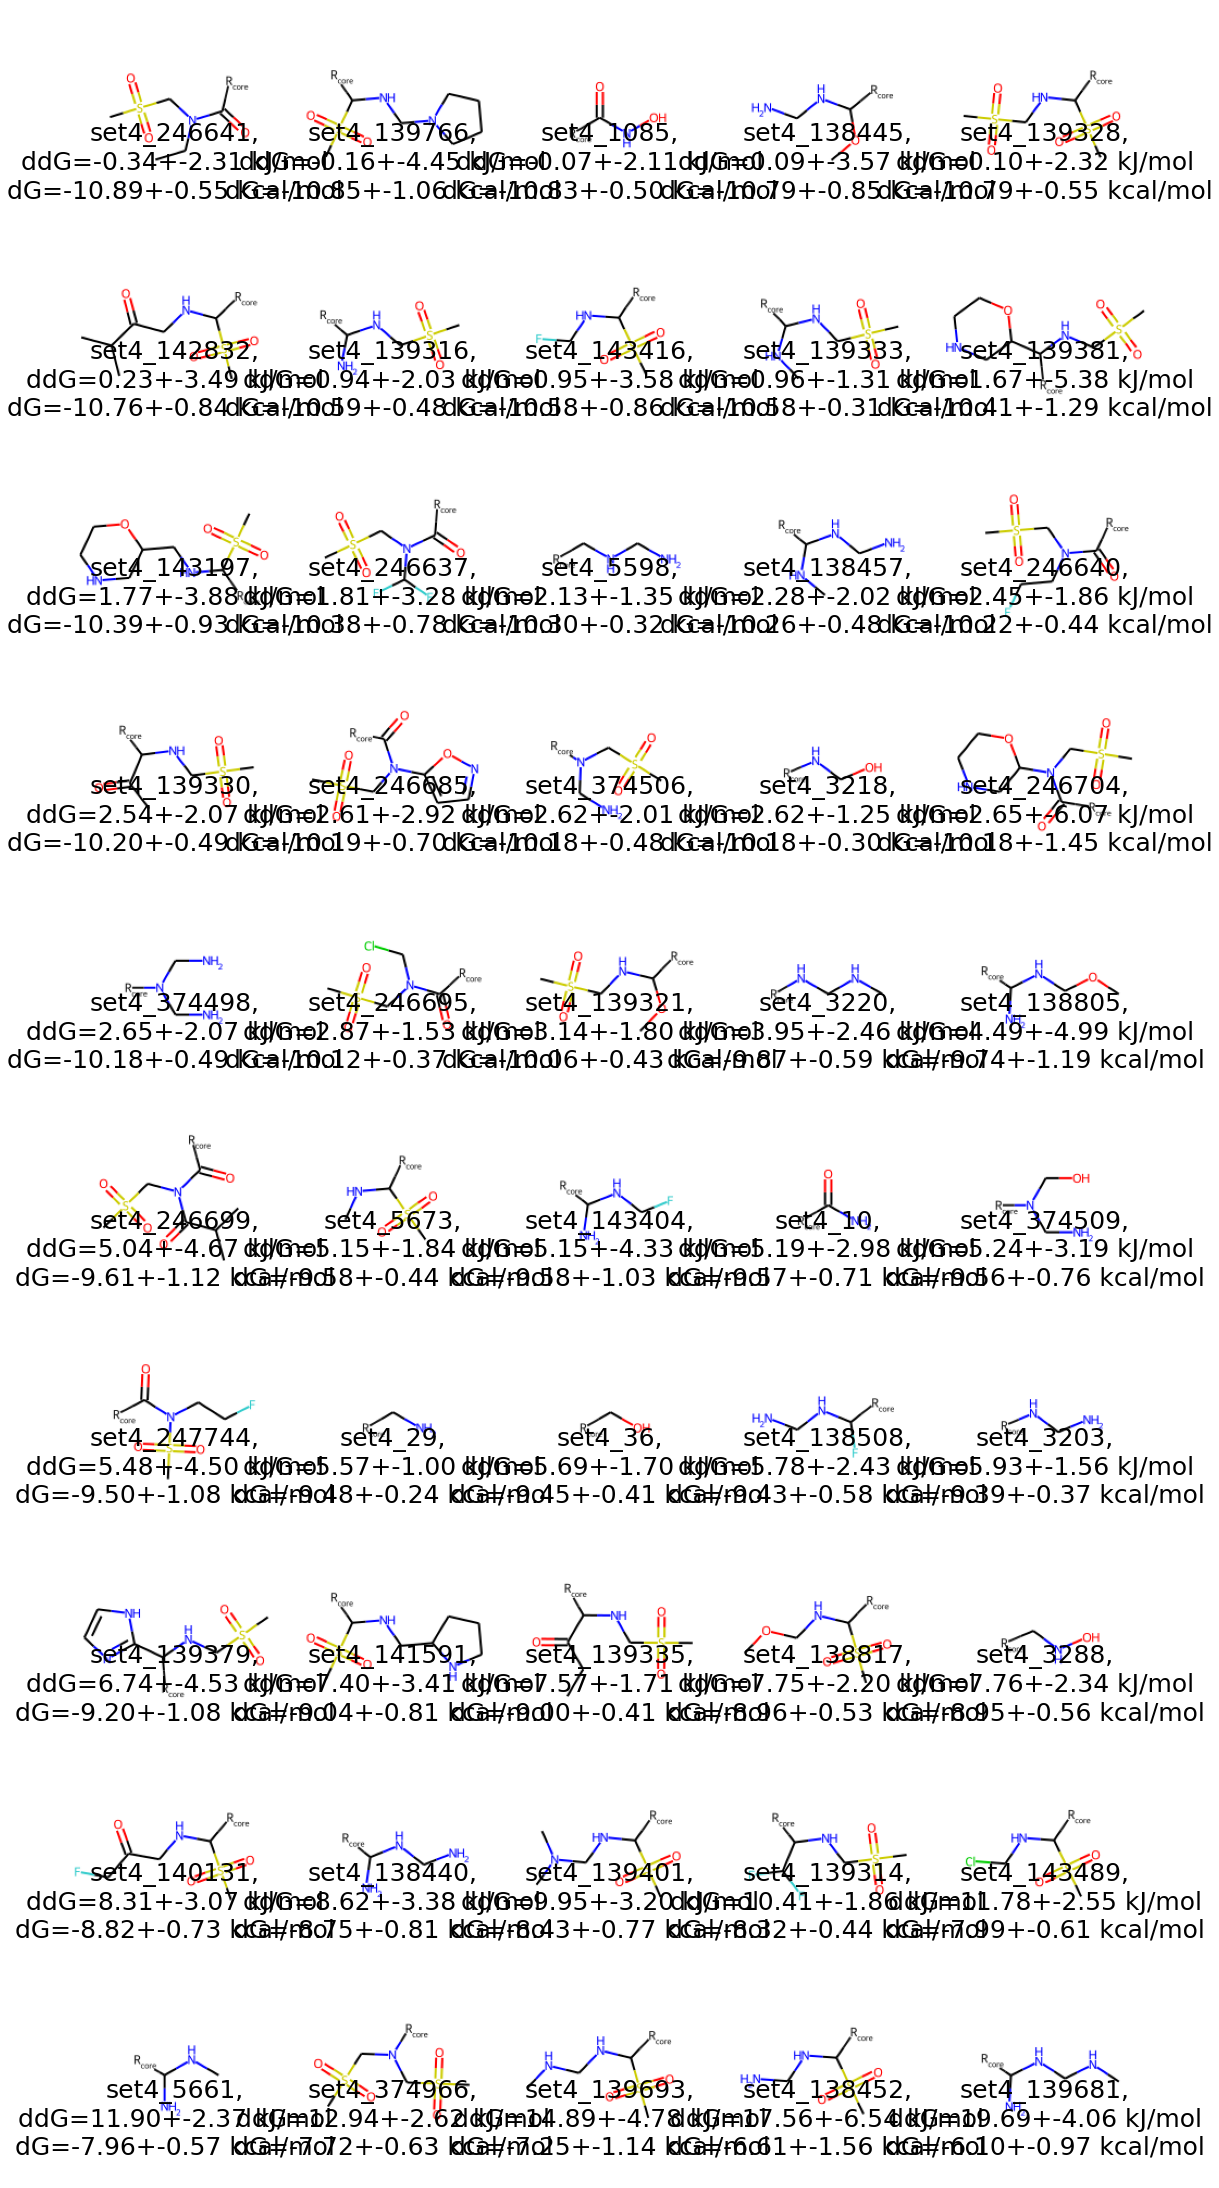

In [70]:
grid_mols_with_annotation(ordered_ligs_Rgroup_only[-50:],
                 labels=[legends[i] for i in order[-50:]],
                 sub_img_size = (200,200), mols_per_row=5, annotation_size=25, y_offset=-25)

### save preliminary results for finished ligands

In [71]:
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

save_ligs=[]
for edge in fe.resultsSummary.index:
    ligname=edge[19:]
    for lig in test_ligs:
        if lig.GetProp('ID')==ligname:
            lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
            lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
            lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
            save_ligs.append(PropertyMol.PropertyMol(lig))
            
print(len(save_ligs))

fname="finished_ligs_prelim.pickle"

with  open( fname, "wb" ) as f:
    pickle.dump(save_ligs, f)

94


# save the stable ligs as a pickle for training

In [ ]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
# red_dG=lig_to_dG(reference_lig)

# save_ligs=[]
# for edge in fe.resultsSummary.index:
#     ligname=edge[19:]
#     for lig in test_ligs:
#         if lig.GetProp('ID')==ligname:
#             lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
#             lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
#             lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
#             save_ligs.append(PropertyMol.PropertyMol(lig))
            
# print(len(save_ligs))

# fname="stable_ligs.pickle"

# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

In [ ]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))

# print(f"ref lig dG: {lig_to_dG(reference_lig)} kcal/mol")

In [ ]:
# # fix the saved ligands' dG values
# fname="stable_ligs.pickle"
# with open(fname, 'rb') as f:
#     save_ligs = pickle.load(f)
    
# red_dG=lig_to_dG(reference_lig)
    
# for i,lig in enumerate(save_ligs):
#     ddG=float(lig.GetProp("ddG"))
#     lig.SetProp("dG", str(ddG + red_dG) ) # kcal/mol
#     save_ligs[i]=PropertyMol.PropertyMol(lig)
    
# fname="stable_ligs_fixed_dG.pickle"
# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# Also write dG value into the big 34K lig DB pickle file

In [72]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step6_dG.pickle"
with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
# with open("stable_ligs.pickle", 'rb') as f:
with open("finished_ligs_prelim.pickle", 'rb') as f:
    step_known_ligs = pickle.load(f)

known_lig_idxs_in_set4f=[]
known_lig_idxs_in_step=[]
known_lig_idxs=[l.GetProp('ID') for l in step_known_ligs]
for i,lig in enumerate(ligs_set4f):
    if(lig.GetProp('ID') in known_lig_idxs):
        known_lig_idxs_in_set4f.append(i)
        known_lig_idxs_in_step.append(known_lig_idxs.index(lig.GetProp('ID')))

In [73]:
print(known_lig_idxs_in_step)
print(known_lig_idxs_in_set4f)

[83, 36, 2, 88, 50, 30, 33, 26, 60, 85, 11, 32, 43, 78, 84, 25, 0, 73, 86, 77, 41, 52, 21, 47, 48, 31, 75, 70, 65, 92, 55, 59, 49, 61, 17, 4, 87, 37, 18, 9, 46, 74, 13, 20, 56, 34, 66, 5, 7, 45, 64, 27, 6, 1, 63, 44, 19, 16, 71, 29, 68, 42, 91, 69, 90, 93, 40, 67, 22, 82, 35, 24, 81, 62, 89, 39, 76, 51, 23, 79, 38, 12, 57, 54, 15, 28, 8, 58, 14, 80, 10, 53, 3, 72]
[5, 18, 23, 340, 350, 551, 553, 1174, 1397, 1412, 1414, 1479, 2536, 2599, 2611, 2701, 15502, 15575, 15580, 15587, 15592, 15638, 15643, 15940, 15952, 16448, 16450, 16455, 16462, 16464, 16467, 16469, 16487, 16493, 16513, 16514, 16515, 16518, 16519, 16535, 16815, 16827, 16900, 17265, 18724, 19961, 20326, 20472, 20533, 20545, 20618, 22582, 22715, 23100, 23417, 23418, 23419, 23420, 23422, 23423, 23424, 23429, 23430, 23431, 23432, 23436, 23437, 23440, 23446, 23450, 23454, 23455, 23456, 23457, 23459, 23461, 23462, 23468, 23469, 23472, 23473, 23474, 23475, 23476, 23478, 23479, 23481, 24095, 24356, 26721, 30633, 30641, 30644, 31101]


In [74]:
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)

fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step6_with_weak_pred_binders_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(ligs_set4f, f)
    
del ligs_set4f

In [75]:
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step6_dG.pickle"

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
    
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=no_core_ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    no_core_ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step6_with_weak_pred_binders_dG.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(no_core_ligs_set4f, f)
    
del no_core_ligs_set4f